In [11]:
using LinearAlgebra
using FFTW
using PyPlot
using Statistics
using Interpolations
#using DataStructures
#using Random, Distributions
#using Measures
#using ProgressBars
#using MultivariateStats
#using CFTime
#using StatsBase
#using JLD
#using Colors
#using HypothesisTests
#using Dates
#using DSP

In [2]:
data_folder = "data/"

"data/"

functions

In [3]:
include("functions/evolve_functions.jl");
include("functions/filters.jl");
#include("functions/smm.jl");
#include("functions/events_characteristics.jl");

In [4]:
include("params/params.jl");
println("Simulation period: ", d1_y, " - ", d2_y);

Simulation period: 1979 - 2021



standard parameters (non dimensional)
Hbar, Qbar, Γ, γ, Abar, Δa, Sref 

--- 
dimensionalization constants
Dₐ(km), Tₐ(h), Θₐ(Kelvin), Uₐ(m/s)  

--- 
simulation specific parameters

L, Nx, dx, Δt, T (total simulation time, dimensionless), Nt
κ (spatial frequencies)

dostocha (stochastic switch)
REPEAT (repetitions to reach equilibrium)

---

longitudes (longitudinal points at which forcing is defined)
Stheta, Sq, Aₛ (forcing profiles & background)

satisfying 
̄HAₛ=(Sq-̄Q*Stheta)/(1-Q) 


In [ ]:
# compute the distribution of eastern most points
#function distribution(values, bin_edges, alpha)
#    val_distribution = zeros(length(bin_edges)-1);
#    error_bars = zeros(length(bin_edges)-1);
#    for i = 1:length(bin_edges)-1
#        b1 = bin_edges[i];
#        b2 = bin_edges[i+1];
#        ns = findall(x->((x>=b1)&(x<b2)), values);
#        phat = length(ns)/length(values);
#        val_distribution[i]=phat;
#        
#        zz = 1-alpha/2;
#        z = quantile.(Normal(), [zz])
#        z = z[1];
#        error_bars[i] = z*sqrt(phat*(1-phat)/length(values));
#        
#    end
#    return val_distribution, error_bars
#end

### Check forcing profiles 

In [5]:
println("The spatial mean of A_s, Sq and Stheta should be equal:\n", round(mean(Hbar*mean_Aₛ[1,:])*15.0*24.0/Tₐ, digits=2), " = ", round(mean(mean_Sq[1,:])*15.0*24.0/Tₐ, digits=2), " = ", round(mean(mean_Stheta[1,:])*15.0*24.0/Tₐ, digits=2) )

The spatial mean of A_s, Sq and Stheta should be equal:
1.63 = 1.63 = 1.63


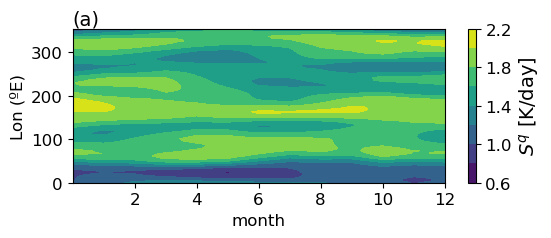

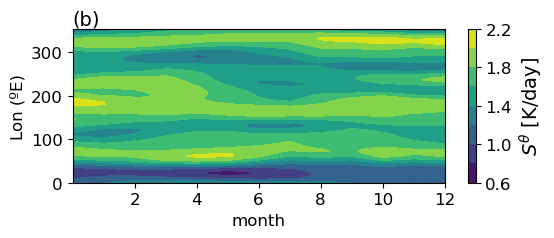

In [8]:
function plot_first_year(months_fine, S, cbar_label, plot_label)
    # profiles are saved in an array (time, space) with Δt = 1.7 hours 
    # find the indices (along the first axis) that belong to the first year of simulation
    idx_first_year = findall(x -> x < 12, floor.(Int, months_fine))
    time_ = months_fine[idx_first_year]

    # Spatial discretization 
    space_ = range(0, stop = 360 - 360 / 64.0, length = 64)
    
    # Mesh
    X = repeat(reshape(space_, 1, :), length(time_))
    Y = repeat(time_, 1, length(space_))

    # Plotting
    fig, ax = subplots(1, 1, figsize = (6, 2))
    im1 = ax.contourf(Y', X', 15.0 * 24.0 / Tₐ .* S[idx_first_year, :]') # dimensionalize Sq for plotting

    # Colorbar and labels
    cbar1 = colorbar(im1)
    cbar1.set_label(cbar_label, fontsize = 14)

    ax.set_xlabel("month", fontsize = 12)
    ax.set_ylabel("Lon (ºE)", fontsize = 12)
    ax.text(0, 365, plot_label, fontsize = 14)
    ax.tick_params(axis = "both", which = "major", labelsize = 12)

    # Customize colorbar ticks
    cbar1.ax.locator_params(nbins = 5)
    cbar1.ax.tick_params(labelsize = 12)

end

plot_first_year(months_fine, Sq, L"$S^q$ [K/day]", "(a)")
plot_first_year(months_fine, Stheta, L"$S^\theta$ [K/day]", "(b)")


## Set Initial Conditions

simulations are initialized with the wavenumber-2 solution to the linearized system


∂ₜK + ∂ₓK = -1/√2 ̄HA


∂ₜR - 1/3*∂ₓR = -2√2/3 ̄HA


∂ₜQ + ̄Q/√2∂ₓK - Q/6√2∂ₓR = (̄Q/6 - 1)̄HA


∂ₜA = ΓQ<Aₛ>

In [15]:
# The wavenumber-2 eigenmode is selected to initialize model.
k=2;
κ2= 2*π*im*2/L;
Mat = -im.*[κ2           0.0           0.0                1/√2*Hbar;
            0.0         -1/3.0*κ2      0.0                2*√2/3.0*Hbar;
            Qbar/√2*κ2  -Qbar/6/√2*κ2  0.0               -(Qbar/6.0- 1.0)*Hbar;
            0.0          0.0           -Γ*(mean(Aₛ[1,:], dims=1))/γ         0.0];
                      
d, V = eigen(Mat); # eignevalues (frequencies) in ascending order

#select MJO mode (slowest eastward propagating wave of the model)
MJO_vec= V[:,3];

initampl = 0.05; 

xx = collect(0:Nx-1)*dx;

K0 = initampl*MJO_vec[1]*exp.(κ2*xx);
R0 = initampl*MJO_vec[2]*exp.(κ2*xx);
Q0 = initampl*MJO_vec[3]*exp.(κ2*xx);
A0 = initampl*MJO_vec[4]*exp.(κ2*xx); 


K0_ref = K0;
R0_ref = R0;
Q0_ref = Q0*γ;
A0_ref = A0*γ .+ real.(mean(Aₛ[:,:], dims = 1)[1,:]); # add background
theta = -1/√2 * (K0_ref .+ R0_ref./2.0).*γ .+ R0_ref./4.0.*γ./√2 ; 
Z0_ref = Q0_ref .+ Qbar.*theta;

## Integration

In [ ]:
NUM_REPEAT = 15 # number of independent runs (! different from REPEAT variable which defines the thermalization period and thus the total length of simulation: Nt)

# store every time step
AA = zeros(Nx,NUM_REPEAT,Nt);
KK = zeros(Nx,NUM_REPEAT,Nt);
RR = zeros(Nx,NUM_REPEAT,Nt);
ZZ = zeros(Nx,NUM_REPEAT,Nt);

# store time steps
times_ = range(Δt, step = Δt, length = Nt)

for nr in (1:NUM_REPEAT)
    
    # initial conditions   
    K0 = real(K0_ref); 
    R0 = real(R0_ref); 
    Q0 = real(Q0_ref); 
    A0 = real(A0_ref); 
    Z0 = real(Z0_ref); 
    
    for tt in (1:Nt)
            
        if dostocha==1
            K1, R1, A1, Z1 = ev_functions.evolve_stocha(K0, R0, Z0, A0, Hbar, Qbar, Stheta[tt,:], Sq[tt,:], Γ, Δt, κ, Δa, Nx);
        else
            K1, R1, A1, Z1 = ev_functions.evolve(K0, R0, Z0, A0, Hbar, Qbar, Stheta[tt,:], Sq[tt,:], Γ, Δt, κ, dx);
        end
        K0 = K1; R0 = R1; Z0 = Z1; A0 = A1;
        
        
        AA[:,nr,tt]=real(A0[:,:]);
        KK[:,nr,tt]=real(K0[:,:]);
        RR[:,nr,tt]=real(R0[:,:]);
        ZZ[:,nr,tt]=real(Z0[:,:]);     
    end   
end

# identify the date that goes with each element of the time array
month_idx = floor.(Int, months_fine);
dates_array = [dates_tmp[i+1] for i in month_idx];
month_array = [dates_tmp[i+1].month for i in month_idx];
year_array = [dates_tmp[i+1].year for i in month_idx];

# find the last 43 years (1979 - 2021)
itk = length(year_array);
while(year_array[itk]>d1_y) # d1_y = 1979
    itk=itk-1;
end
while(year_array[itk]==d1_y) # d1_y = 1979
    itk=itk-1;
end
itk = itk+1;

dates_output = dates_array[itk:end]; 
times = times_[itk:end];

# select last 43 years of the simulation outputs
AA = AA[:,:,itk:end]; 
KK = KK[:,:,itk:end]; 
RR = RR[:,:,itk:end];
ZZ = ZZ[:,:,itk:end]; 


# free memory
K0 = nothing;
R0 = nothing;
Q0 = nothing;
A0 = nothing;
Z0 = nothing;

K0_ref = nothing;
R0_ref = nothing;
Q0_ref = nothing;
A0_ref = nothing;
Z0_ref = nothing;


LoadError: InterruptException:

In [ ]:
# recover variables in dimensional units
u = (1/√2 .*(KK .- RR./2.0)*γ .- (RR/4.0).*(γ/√2))*50; #[m/s] ϕ₀(0)= γ = (π)^(-1/4.) 
theta = -1.0/√2 .*(KK .+RR./2.0)*γ .+ (RR/4.0).*(γ/√2);
q = (ZZ .- Qbar*theta)*15; # [K]
theta = theta*15; # [K]
ha = Hbar.* AA*15.0*24.0/Tₐ; # [K/day]

## Filter intraseasonal signal and plot data

In [ ]:
sim_day, months_tracked, u_daily, u_daily_filtered, ha_daily, ha_daily_filtered, q_daily, q_daily_filtered, theta_daily, theta_daily_filtered = 
    filters.filter(
        month_array[itk:end], u, theta, q, ha, Qbar, Hbar, γ, Tₐ, times, length(times), Nx, NUM_REPEAT
        );



sim_day = floor.(times*Tₐ/24)
months_tracked_ = zeros(length(unique(sim_day))) # for each simulation day we'll need to know to which month it corresponds
years_tracked = zeros(length(unique(sim_day))) # and to which year
i=1
for d in unique(sim_day)
    idxs = findall(sim_day .== d);
    months_tracked_[i] = mean(month_array[itk:end][idxs]); 
    years_tracked[i] = mean(year_array[itk:end][idxs]);
    i+=1;
end
sim_day = unique(sim_day);



Nd = size(sim_day)[1]; # number of simulation days



# save("./data/variables.jld", "u_daily", u_daily, "u_daily_filtered", u_daily_filtered, "ha_daily", ha_daily, "ha_daily_filtered", ha_daily_filtered)

### Plot the space-time evolution of u and ha (without and with spatio-temporal filtering)

In [ ]:
# apply spatial filter to the temporally (intraseasonally) filtered fields 

u_daily_filtered_space = zeros(size(u_daily_filtered));
ha_daily_filtered_space = zeros(size(ha_daily_filtered));

Nd = size(ha_daily)[3];

maxk=4 # max wave number (planetary waves)
for nr in 1:NUM_REPEAT
    for ts in 1:Nd # filter each time step separately
        # wind
        fH = fftshift(fft(u_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        u_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
        
        # convective activity
        fH = fftshift(fft(ha_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        ha_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
    end
end



In [ ]:
time_ = 1:360; 
space_ = range(0, stop=360-360/64.0, length=64) 
X = repeat(reshape(space_, 1, :), length(time_), 1);
Y = repeat(time_, 1, length(space_));


nr = 15
year = 2005.0; 
interval = findall(x->x==year, years_tracked);
fig, axs = subplots(1,4, figsize = (6,6))
im1 = axs[1].contourf(X,Y, u_daily[:,nr,interval]', levels = LinRange(-40, 40, 9) )
im2 = axs[2].contourf(X,Y, ha_daily[:,nr,interval]', levels = LinRange(0, 25, 6))
im3 = axs[3].contourf(X,Y, u_daily_filtered_space[:,nr,interval]', levels = LinRange(-10, 10, 7))
im4 = axs[4].contourf(X,Y, ha_daily_filtered_space[:,nr,interval]', levels = LinRange(-2, 2, 6))

p1 = axs[1].get_position().get_points()
p1 = [(p1...)...]
p2 = axs[2].get_position().get_points()
p2 = [(p2...)...]
p3 = axs[3].get_position().get_points()
p3 = [(p3...)...]
p4 = axs[4].get_position().get_points()
p4 = [(p4...)...]



ax_cbar1 = fig.add_axes([p1[1], -0.04, p1[2]-p1[1], 0.05])
ax_cbar2 = fig.add_axes([p2[1], -0.04, p2[2]-p2[1], 0.05])
ax_cbar3 = fig.add_axes([p3[1], -0.04, p3[2]-p3[1], 0.05])
ax_cbar4 = fig.add_axes([p4[1], -0.04, p4[2]-p4[1], 0.05])


cbar1 = colorbar(im1, cax=ax_cbar1, orientation="horizontal")
cbar2 = colorbar(im2, cax=ax_cbar2, orientation="horizontal")
cbar3 = colorbar(im3, cax=ax_cbar3, orientation="horizontal")
cbar4 = colorbar(im4, cax=ax_cbar4, orientation="horizontal")

ax_cbar1.set_xticklabels(ax_cbar1.get_xticklabels(), rotation=90)
ax_cbar2.set_xticklabels(ax_cbar2.get_xticklabels(), rotation=90)
ax_cbar3.set_xticklabels(ax_cbar3.get_xticklabels(), rotation=90)
ax_cbar4.set_xticklabels(ax_cbar4.get_xticklabels(), rotation=90)


ax_cbar1.set_xlabel(L"$u$ [m/s]")
ax_cbar2.set_xlabel(L"$\bar{H}a$ [K/s]")
ax_cbar3.set_xlabel(L"filt. $u$ [m/s]")
ax_cbar4.set_xlabel(L"filt. $\bar{H}a$ [K/s]")


axs[1].set_ylabel("day")

axs[1].set_xlabel("Lon (ºE)")
axs[2].set_xlabel("Lon (ºE)")
axs[3].set_xlabel("Lon (ºE)")
axs[4].set_xlabel("Lon (ºE)")

axs[2].set_yticks([])
axs[3].set_yticks([])
axs[4].set_yticks([])


axs[1].text(1, 362, "(a)")
axs[2].text(1, 362, "(b)")
axs[3].text(1, 362, "(c)")
axs[4].text(1, 362, "(d)")


# plot speed indications on panel (d) - change/adapt by hand 
a = -90/360;
b = 345;
line1 = a.*space_.+b;
axs[4].plot(space_[21:51], line1[21:51], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 275, "-5.1 m/s", color = "white")


a = 70/360;
b = -5;
line2 = a.*space_.+b;
axs[4].plot(space_[11:61], line2[11:61], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 45, "6.6 m/s", color = "white")



### spatio-temporal spectrum

In [39]:
function padreplicate(a, padSize)
    # Pad an array by replicating values.
    numDims = length(padSize);
    idx = [];
    for k = 1:numDims
        M = size(a)[k];
        onesVector = ones(Int, padSize[k]);
        push!(idx, vcat(onesVector, (1:M), M .*onesVector));
    end   
    return a[idx[1], idx[2]]
end
    

function spectrum(term, Nx, nd)
    
    for iii in 1:Nx
        term[iii,:] = term[iii,:] .- mean(term[iii,:]);
    end
    termhat = fftshift(fft(term)); term = 0;
    term = termhat.*conj(termhat)/nd/Nx/nd/Nx; termhat=0;
    term = log10.(term);
    return term
end


In [ ]:
nxsmoo=     1; # x size of smooth (odd) (ref=1)
ntsmoo=     51; # t size of smooth (odd) (ref=25)
undersamplext=    1 ; # undersample outputs to be faster
nku=1; # k-space between samples 
nwu=11; # w-space between samples 

tcon=vcat(zeros(1),0:Nd-1);
ts = tcon; tcon = 0;

kg =-fftshift(fftfreq(Nx,Nx));
NNd = length(ts);
wg = fftshift(fftfreq(NNd,NNd))/NNd;


####################################
term = ha_daily[:,1,:];
xcon=((1:Nx)*0);
xcon=hcat(xcon,term);  
term_all = xcon; xcon = 0;

for nr in 2:NUM_REPEAT
    term = ha_daily[:,nr,:];
    
    xcon=((1:Nx)*0);
    xcon=hcat(xcon,term);  
    term = xcon; xcon = 0;
    
    term_all = term_all .+ spectrum(term, Nx, Nd)
end
term = term_all./NUM_REPEAT;
term_all = 0;

#############################

# smooth data
sz = [nxsmoo,ntsmoo]'; # x size of smooth, t size of smooth
padSize = Int.((sz .-1) ./2);
smooth_ = ones((sz[1],sz[2])) ./ (sz[1]*sz[2]); 

# pad data
X = padreplicate(term,padSize);
# perform the convolution
Y = conv(X, smooth_)  # Convolution (1 dimensional convolution, I think)

# Extract the 'valid' part of the result
Y_valid = Y[:,1:size(X)[2]];
Y_valid = Y_valid[:,padSize[2]+1:end-padSize[2]];

# undersample for figure
PSD=real.(Y_valid[1:nku:end,1:nwu:end]);
kg=kg[1:nku:end];
wg=wg[1:nwu:end]; 


################################

# graph ranges
xxrange=[-5,5]; yyrange=[1/100,0.1]; 
kwlevels= -7.5:0.5:-3;

# figure
fig = figure(figsize=(8,6))

aspect_ratio = (5 - (-5)) / (0.1 - (1 / 100))
contourf(kg, wg, PSD', levels = kwlevels,  cmap = :jet)
cbar = colorbar()

axhline(y = 1/30, linestyle = "--", color = "black")
text(3.2, 0.0345, "30 days", fontsize=16)
axhline(y = 1/90, linestyle = "--", color = "black")
text(3.2, 0.0125, "90 days", fontsize=16)

xlabel("k (2pi/40000km)", fontsize=18)
ylabel("freq (cpd)", fontsize=18)

xlim(xxrange)
ylim(yyrange)

cbar.set_ticks([-7,-6,-5,-4, -3])
cbar.set_label(L"Log(Power of $\bar{H}a$)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

tick_params(axis="both", which="major", labelsize=16)



### climatological mean state of convective activity

In [58]:
# reference values from observation

mean_state_obs = [0.63447047, 0.82385311, 1.05512592, 1.29748726, 1.41143023, 1.32072308, 1.07110377, 0.89125782, 0.65923143, 0.78365783, 0.97064447, 1.28288174, 1.49286871, 1.88178154, 1.90932694, 2.12785873, 2.48477829, 2.46821673, 2.35731323, 2.02154449, 2.48440132, 2.03148743, 1.85023753, 2.04074861, 2.40357981, 2.71217909, 2.64640965, 2.72319167, 2.57775551, 2.5080159 , 2.35830829, 2.24817153, 2.14220128, 1.99026377, 1.89041525, 1.76442461, 1.60944299, 1.46777352, 1.36271398, 1.28796875, 1.22224235, 1.17223835, 1.14222169, 1.11389481, 1.05066333, 1.07003877, 1.04454191, 1.08771372, 1.09866436, 1.24381045, 1.98811522, 2.2297906 , 2.41858673, 2.19152191, 2.0437829 , 2.08161911, 1.58913953, 1.46284294, 1.52265101, 1.20310833, 0.95069025, 0.82309336, 0.82941141, 0.60837749];
var_ha_obs = [0.43246531, 0.79090576, 0.90166614, 0.92764241, 0.94539983, 0.76263027, 0.80707566, 0.7501988 , 0.45969607, 0.550354  , 1.17024631, 1.62570271, 1.93585149, 2.2108578 , 2.19037681, 2.17013884, 2.99504139, 1.67945985, 1.5613739 , 1.15216685, 1.83886877, 1.63465783, 1.82081677, 1.93685682, 1.98879794, 2.79857672, 3.12145777, 2.64759241, 2.75669806, 1.72678987, 2.08827863, 1.32042655, 1.44514434, 1.17147252, 1.22025861, 0.98381031, 0.80393361, 0.71861616, 0.78857414, 0.79116691, 0.66827126, 0.6018239 , 0.68875867, 0.8182729 , 0.6242256 , 0.80900001, 0.7558489 , 0.72179167, 0.673626  , 0.79210501, 2.1637858 , 2.07509846, 1.98484548, 1.72748955, 2.2801776 , 2.33459525, 1.38794117, 0.92793855, 1.00869495, 0.57474102, 0.51992793, 0.58302229, 0.70899668, 0.48352196];
lon_obs = [  1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25, 18.75,  21.25,  23.75,  26.25,  28.75,  31.25,  33.75, 36.25,  38.75,  41.25,  43.75,  46.25,  48.75,  51.25, 53.75,  56.25,  58.75,  61.25,  63.75,  66.25,  68.75, 71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25, 88.75,  91.25,  93.75,  96.25,  98.75, 101.25, 103.75,106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25,123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75,141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25,158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75,176.25, 178.75, 181.25, 183.75, 186.25, 188.75, 191.25,193.75, 196.25, 198.75, 201.25, 203.75, 206.25, 208.75,211.25, 213.75, 216.25, 218.75, 221.25, 223.75, 226.25,228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75,246.25, 248.75, 251.25, 253.75, 256.25, 258.75, 261.25,263.75, 266.25, 268.75, 271.25, 273.75, 276.25, 278.75,281.25, 283.75, 286.25, 288.75, 291.25, 293.75, 296.25,298.75, 301.25, 303.75, 306.25, 308.75, 311.25, 313.75,316.25, 318.75, 321.25, 323.75, 326.25, 328.75, 331.25,333.75, 336.25, 338.75, 341.25, 343.75, 346.25, 348.75,351.25, 353.75, 356.25, 358.75];


320.625

In [ ]:
ha_daily_filtered_smoothed = zeros(size(ha_daily_filtered))
maxk = 14
for nr in 1:NUM_REPEAT
    for ts in 1:Nd # filter each time step separately
        fH = fftshift(fft(ha_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >maxk , freqs);
        fH[idx1].=0;
        
        ha_daily_filtered_smoothed[:,nr,ts] = real(ifft(ifftshift(fH)));
    end
end

mean_state = mean(ha_daily, dims = (2,3));

variance_ha = var(ha_daily_filtered[:,1,:], dims = 2);
for i in 2:NUM_REPEAT
    variance_ha = variance_ha .+ var(ha_daily_filtered[:,i,:], dims = 2);
end
variance_ha = variance_ha./NUM_REPEAT;


variance_ha_smoothed = var(ha_daily_filtered_smoothed[:,1,:], dims = 2);
for i in 2:NUM_REPEAT
    variance_ha_smoothed = variance_ha_smoothed .+ var(ha_daily_filtered_smoothed[:,i,:], dims = 2);
end
variance_ha_smoothed = variance_ha_smoothed./NUM_REPEAT;

In [58]:


fig, axs = subplots(1,3, figsize = (14*0.94,4*0.94))#, constrained_layout=true)
fig.tight_layout(pad=2.8) 
#fig.subplots_adjust(hspace=0.6)

axs[1].plot(longitudes, mean_state_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[1].plot(longitudes, mean_state[:,1,1], label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[1].set_xlabel("lon", fontsize = 18)
axs[1].set_ylabel(L"$\bar{H}a_s$", fontsize = 18)

axs[1].legend(fontsize =14, loc = "upper right")
axs[1].set_xlim([0, 358])
axs[1].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[1].text( 3,2.9, "(a)", fontsize = 18)


axs[2].plot(longitudes, var_ha_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[2].plot(longitudes, variance_ha, label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[2].set_xlabel("lon", fontsize = 18)
axs[2].set_ylabel(L"var($\bar{H}a$)", fontsize = 18)

axs[2].legend(fontsize =14)
axs[2].set_xlim([0, 358])
axs[2].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[2].text( 3,7.42, "(b)", fontsize = 18)#3.05 6.8



axs[3].plot(longitudes, var_ha_obs, label = "Obs", linestyle = "-", color = "black", linewidth = 2)
axs[3].plot(longitudes, variance_ha_smoothed, label = "Model", linestyle = "--", color = "cornflowerblue", linewidth = 3)

axs[3].set_xlabel("lon", fontsize = 18)
axs[3].set_ylabel(L"var($\bar{H}a_{14}$)", fontsize = 18)

axs[3].legend(fontsize =14)
axs[3].set_xlim([0, 358])
axs[3].set_xticks([0, 60, 120, 180,240, 300, 360])
axs[3].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W", "0"]);

axs[3].text( 3,3.32, "(c)", fontsize = 18)#3.05 6.8

axs[1].tick_params(axis="both", which="major", labelsize=14)
axs[2].tick_params(axis="both", which="major", labelsize=14)
axs[3].tick_params(axis="both", which="major", labelsize=14)




### Empirical Orthogonal functions analysis and Skeleton Multivariate MJO Index

In [429]:
# for each independent repetition of the simulation, compute Principal Components and SMM index values 
Nd = size(ha_daily)[3];
SMM1 = zeros(NUM_REPEAT, Nd);
SMM2 = zeros(NUM_REPEAT, Nd);
amplitude = zeros(NUM_REPEAT, Nd);
phase = zeros(NUM_REPEAT, Nd);

i=1
var1, var2, PC1, PC2, amplitude[1,:], phase[1,:], SMM1[1,:], SMM2[1,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); 
for i in 2:NUM_REPEAT
    var1_tmp, var2_tmp, PC1_tmp, PC2_tmp, amplitude[i,:], phase[i,:], SMM1[i,:], SMM2[i,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); 
    var1 = var1 + var1_tmp;
    var2 = var2 + var2_tmp;
    PC1 = PC1 .+ PC1_tmp;
    PC2 = PC2 .+ PC2_tmp;
end

# compute mean PC and variance over the 15 independent runs (for plotting)
var1 = var1 / NUM_REPEAT;
var2 = var2 / NUM_REPEAT;
PC1 = PC1 ./ NUM_REPEAT;
PC2 = PC2 ./ NUM_REPEAT;

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

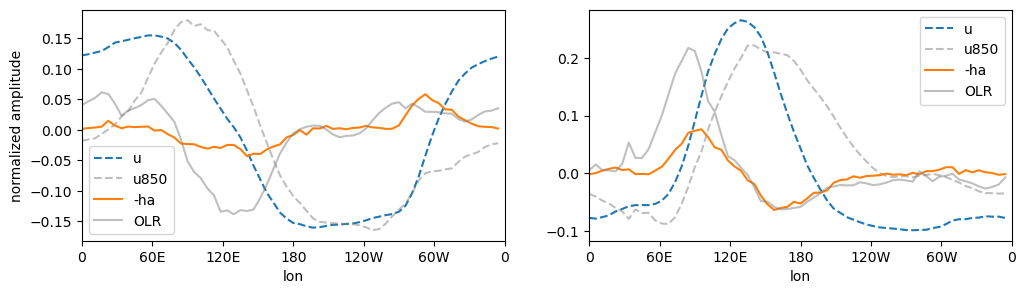

In [430]:
# plot EOFs (mean over the 15 independent runs)

fig, axs = subplots(1,2, figsize = (14,3))

axs[1].plot(longitudes, PC1[1:64]./var1, label = L"$u$", color = "steelblue")
axs[1].plot(longitudes, PC1[65:end]./var1, label = L"$-\bar{H}a$", color = "tomato")
axs[2].plot(longitudes, PC2[1:64]./var2, label = L"$u$", color = "steelblue")
axs[2].plot(longitudes, PC2[65:end]./var2, label = L"$-\bar{H}a$", color = "tomato")


axs[1].text(1, 1.4, "EOF1", fontsize = 16)
axs[2].text(1, 2.68, "EOF2", fontsize = 16)


axs[1].set_xlabel("lon", fontsize=14)
axs[2].set_xlabel("lon", fontsize=14)

axs[1].set_ylabel("normalized amplitude", fontsize=14)

axs[1].legend(fontsize=14, loc="upper right")
axs[2].legend(fontsize=14)

axs[1].set_xlim([0, 354])
axs[2].set_xlim([0, 354])

axs[1].set_xticks([0, 60, 120, 180,240, 300])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[2].set_xticks([0, 60, 120, 180,240, 300])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[1].tick_params(axis="both", which="major", labelsize=14)
axs[2].tick_params(axis="both", which="major", labelsize=14)



## Identify MJO events and compute their characteristics


In [672]:
seqs = []
for nr in 1:NUM_REPEAT
    seq = events.identify(amplitude[nr,:], phase[nr,:]);
    push!(seqs,seq);
end

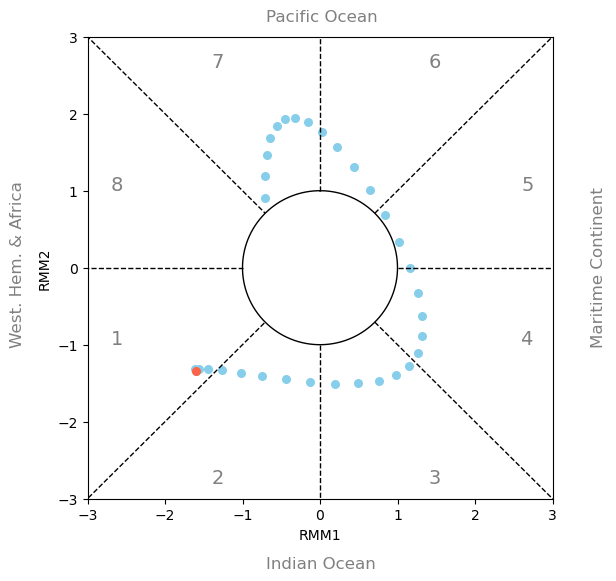

In [674]:
# select one event and plot its phase-space diagram
ii1 = 14576+9;
ii2 = 14576+41;
events.phase_space_diagram(SMM1[15,:], SMM2[15,:], ii1, ii2, amplitude[15,:])

## Seasonal variability

count number of events in each month

In [690]:
seasonal_var = zeros(12);
for nr in 1:NUM_REPEAT
    seq = seqs[nr];
    num_events = size(seq)[1];
    for i in 1:num_events
        m1 = Int(seq[i,1]);
        m2 = Int(seq[i,2]);
        event_months = months_tracked[m1:m2];
        for em in unique(event_months)
            seasonal_var[Int(em)]+=1;
        end
    end
end

In [732]:
seasonal_ref = [34.0, 30.0, 41.0, 38.0, 39.0, 25.0, 11.0, 9.0, 14.0, 28.0, 25.0, 35.0];


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


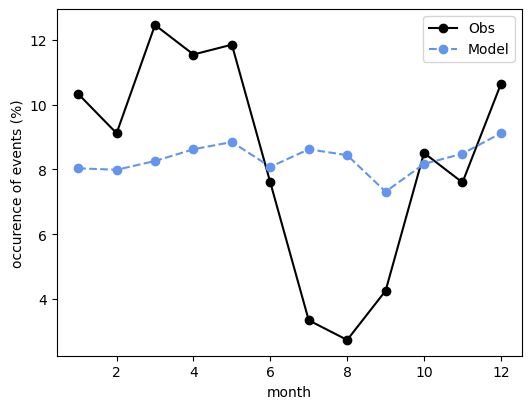

In [733]:
fig, ax = subplots(1,1, figsize = (4*1.5,3*1.5))

ax.plot(1:12,seasonal_ref./sum(seasonal_ref)*100, "-o", label = "Obs", color = "black") 
ax.plot(1:12,seasonal_var./sum(seasonal_var)*100, "--o", label = "Model", color = "cornflowerblue") # might be shifted backwards by 15 days

ax.set_xlabel("month")
ax.set_ylabel("occurence of events (%)")

ax.legend()
savefig("figures/seasonality.eps", dpi = 400, format="eps", bbox_inches="tight")


## Yearly variability

In [693]:
yearly_var = zeros(43);
for nr in 1:NUM_REPEAT
    seq = seqs[nr];
    num_events = size(seq)[1];
    for i in 1:num_events
        y1 = Int(seq[i,1]);
        y2 = Int(seq[i,2]);
        event_years = years_tracked[y1:y2];
        for ey in unique(event_years)
            yearly_var[Int(ey)-1978]+=1;
        end
    end
end

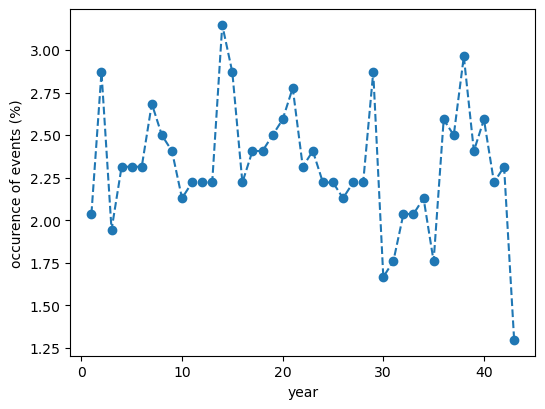

PyObject Text(24.000000000000007, 0.5, 'occurence of events (%)')

In [694]:
fig, ax = subplots(1,1, figsize = (4*1.5,3*1.5))

ax.plot(1:43,yearly_var./sum(yearly_var)*100, "--o") 

ax.set_xlabel("year")
ax.set_ylabel("occurence of events (%)")



In [190]:
findall(x-> x == maximum(yearly_var), yearly_var)

1-element Vector{Int64}:
 14

In [192]:
1979+14

1993

### Number of events

In [734]:
num_events = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    num_events[nr] = events.number(seqs[nr]);
end
mean_num_events = mean(num_events);
std_num_events = std(num_events);
println("Average total number of events :", mean_num_events, " +/- ", std_num_events)
println("Average number of events per year : ", mean_num_events/(Nd/365), " +/- ",  std(num_events/(Nd/365)))

Average total number of events :65.33333333333333 +/- 6.183695920571713
Average number of events per year : 1.546476437527021 +/- 0.14637153119381807


### Duration 

In [735]:
duration_ref = [43.0, 51.0, 35.0, 38.0, 48.0, 20.0, 18.0, 34.0, 19.0, 18.0, 21.0, 42.0, 65.0, 70.0, 18.0, 20.0, 18.0, 39.0, 36.0, 43.0, 36.0, 26.0, 39.0, 22.0, 31.0, 14.0, 37.0, 45.0, 29.0, 21.0, 76.0, 16.0, 48.0, 52.0, 153.0, 24.0, 14.0, 54.0, 40.0, 21.0, 21.0, 29.0, 18.0, 30.0, 23.0, 45.0, 41.0, 24.0, 32.0, 23.0, 43.0, 35.0, 23.0, 16.0, 51.0, 41.0, 43.0, 47.0, 24.0, 44.0, 64.0, 17.0, 43.0, 17.0, 25.0, 75.0, 25.0, 27.0, 35.0, 39.0, 81.0, 60.0, 31.0, 32.0, 24.0, 40.0, 14.0, 25.0, 85.0, 29.0, 46.0, 20.0, 15.0, 14.0, 65.0, 22.0, 77.0, 30.0, 25.0, 31.0, 20.0, 24.0, 70.0, 23.0, 14.0, 51.0, 26.0, 50.0, 30.0, 24.0, 37.0, 19.0, 100.0, 25.0, 41.0, 48.0, 29.0, 52.0, 29.0, 40.0, 21.0, 29.0, 29.0, 17.0, 17.0, 12.0, 19.0, 23.0, 32.0, 28.0, 86.0, 25.0, 81.0, 13.0, 29.0, 28.0, 28.0, 16.0, 25.0, 38.0, 38.0, 62.0, 45.0, 40.0, 26.0, 25.0, 19.0, 55.0, 25.0, 14.0, 89.0, 26.0, 33.0, 23.0, 73.0, 56.0, 49.0, 22.0, 47.0, 20.0, 64.0, 11.0, 37.0];
mean_duration_ref = mean(duration_ref);

durations = [];
mean_durations = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqs[nr]);
    append!(durations, durations_nr);
    mean_durations[nr] = mean(durations_nr);
end

mean_duration = mean(mean_durations);
std_duration = std(mean_durations);

println("Mean duration :", mean_duration, " +/- ", std_duration, " vs ", mean_duration_ref, " in reality.")

Mean duration :39.566329442883834 +/- 2.9549908284673183 vs 36.12418300653595 in reality.


### Angle

In [736]:
angle_ref = [8.231361433980151, 6.521913674678556, 4.937017439860323, 2.618226747303696, 5.706097255485039, 3.730330878309978, 2.633462368347161, 5.408194160006371, 2.956117791002831, 3.5618588414097965, 2.8872830332496444, 3.7839027323578986, 5.553338762188588, 6.841554694360584, 3.6057756256524347, 3.4274333776136667, 2.6141842718143913, 6.552369697082918, 3.9269210269915673, 5.2888599039434085, 4.617199937606468, 3.746135696437136, 5.637561733489105, 2.3960088468369354, 4.090287590407964, 2.43081649403295, 4.853887796727675, 3.0620697825564944, 3.168755379906231, 2.4718202325857392, 9.37262907567839, 3.872392809929147, 4.971801147025561, 6.608608184067237, 21.209269111460685, 4.868761227527477, 2.5165781009680463, 7.923671223634278, 2.59677984127235, 2.81386676945623, 3.14234826245822, 2.4218733054948225, 2.45068034970608, 4.749885857483365, 2.5410377691324246, 6.909045162995007, 6.319761076064756, 5.019348616137907, 4.847470307310038, 2.6663179626412434, 4.076564382369301, 4.1269530453301515, 2.4564385001992144, 2.5782776978893773, 8.15715119076666, 2.545396290471709, 5.32453927945679, 6.300756483517633, 3.509313436653891, 5.732763590042552, 5.592491016078137, 2.970904829508907, 6.493083833421072, 3.817282665232919, 2.56629994895041, 8.68796385224021, 2.5327228929215897, 2.5265597305042133, 3.436686937017445, 3.7097553548905937, 11.695544963750262, 4.214625716440128, 3.025691583987051, 3.6883205117187376, 3.0226759635853955, 4.7923788711573, 2.751019351875076, 4.246793293722759, 10.945866405251408, 4.33171905482677, 5.94549109321282, 2.6084162514964118, 2.4885666893241023, 3.0275241995686066, 5.6755845252091355, 3.1870126281239854, 8.962267446391477, 4.229345892465792, 3.6507747266569206, 2.7579345304254343, 3.4943697814461525, 3.574236643329646, 12.032264358147495, 3.5482172743092724, 3.1057751250566, 7.303924432831236, 3.000111986420371, 6.47164866541652, 2.4571058875569314, 3.0691065931853645, 4.082680538059893, 2.4654836674739373, 15.387221661985624, 3.1419969305641113, 5.546615828836607, 3.848135840141258, 3.851286232953449, 7.919710064372241, 2.608563977974617, 5.940693324369062, 3.9838619367388524, 2.686943039155107, 4.099183167920551, 2.564227516023216, 2.936055908898063, 2.461648510966678, 2.9854359685748775, 3.9650343297618256, 3.6746978841251288, 4.092356318315287, 9.960910355342008, 3.141345096795246, 10.413694510310032, 2.8185458226631854, 4.67062663983932, 2.4419568744719813, 3.5038024426000836, 2.919586105680818, 4.142248114574398, 3.4726653676834345, 5.486213696481422, 6.652712597446654, 4.913627678106008, 4.045225908576436, 3.9860825235965907, 4.299087869372429, 4.384123250908747, 8.784150516065235, 2.8695463855093584, 2.7456236840881276, 9.498597891595077, 4.142314719616992, 4.188926038573834, 2.486364135074254, 12.43424080538299, 6.365098868165704, 6.409129245882047, 3.017089076920911, 8.61640860271514, 3.429046931688904, 8.413805938516958, 2.418700133093108, 3.818995554912695];
mean_angle_ref = mean(angle_ref);
angles = [];

mean_angles = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqs[nr], phase[nr,:]);
    append!(angles, angles_nr);
    mean_angles[nr] = mean(angles_nr);
end

mean_angle = mean(mean_angles);
std_angle = std(mean_angles ./2 ./pi);

println("Mean angle :", mean_angle/2/pi, " +/- ", std_angle, " * 2pi vs ", mean_angle_ref/2/pi, " *2pi in reality.")

Mean angle :0.7541762745592597 +/- 0.05767573301837588 * 2pi vs 0.7538133782358352 *2pi in reality.


### RMM

In [737]:
maxRMM_ref = [2.8529141945094234, 3.18326593020001, 2.5730672159972334, 2.560453311046767, 2.2804545157560936, 1.971703503311463, 2.0038653150692847, 2.0916943290493095, 1.7941247655599992, 1.9217307832035093, 1.6750912831782776, 1.9899673658656858, 2.82319261847022, 3.9708496986795225, 1.8870949066161524, 1.2847433960800845, 2.140783336210209, 2.8297045709235054, 3.5423592911068806, 2.956217317054722, 2.5047275274371223, 2.3331720338364117, 2.771639317287604, 1.6990171781404992, 2.0226191881560807, 1.7402078855941228, 2.7415565215308804, 2.357066611810372, 2.7724097222934936, 2.195449017116233, 3.896407356878224, 2.0856834149757697, 2.6891576957312022, 2.3173939335646336, 3.265115165621057, 2.079595043964809, 1.7486135756017074, 2.795104689224681, 2.5619356770708803, 1.8721983601892955, 2.2818496196300964, 2.4753835615512276, 1.9583233257580688, 2.537549690595498, 1.5508672553707283, 3.166442387418856, 2.0400039555746234, 2.3576913349121105, 2.874445852232285, 2.541863116851165, 2.949054834557202, 2.0724380075341884, 2.0703579699722017, 2.624274422133287, 2.0852844277879146, 2.1303913035675723, 2.373917315834209, 2.543224663994461, 2.9964344737692907, 3.520006378222405, 3.800923164693433, 2.60556087425328, 3.122265150553778, 1.9729803361381917, 3.5659960188729936, 3.1073034505660924, 2.157956443776215, 1.583059337460059, 2.4404292404758308, 2.5590314475439135, 2.2478005958166465, 2.780986881347609, 2.4501448409456783, 2.131476217705569, 2.118353039047557, 1.8845300343972133, 1.8191631655362426, 2.864190069680494, 2.952905909983812, 2.296241340914584, 2.553170322084152, 2.865093705221746, 2.3105945133326355, 1.8758087262845318, 3.383564380431967, 1.7694720035492308, 2.8754769010212016, 3.0391943842181783, 2.4686515140475223, 1.9754037455421969, 2.015966573145378, 2.084164317840185, 3.6698532917160174, 2.668967855457301, 1.388626810464249, 2.6374714259476675, 1.7313229547266635, 2.9702649594949446, 2.818902440179339, 2.5522358173086026, 2.3434446325003737, 2.543913161140251, 3.278273557472131, 2.7862559915853278, 3.08755017370794, 2.2937431337407754, 2.430346166131975, 2.799555314706407, 2.1678273698895554, 2.439334947615954, 2.0666798318960473, 2.25962043386393, 1.833490015655922, 2.2128995620121876, 2.8421255487802664, 1.2920688895986627, 1.8628646534010889, 2.4552598846922047, 3.563406316238361, 2.3242471921134844, 3.3994434336172428, 2.0537035808016015, 2.621492765799604, 2.4401461834476734, 2.2041104031392176, 2.5935076263685386, 2.2740592706180744, 2.6645713541462843, 2.4790034836630594, 2.920108837982375, 4.5766515406081, 3.961270367213301, 2.8439270229463807, 2.725983984004178, 1.6280060828589422, 2.2403566299908007, 2.44036876874557, 3.197680360697932, 3.381162635559701, 1.8128931345067774, 3.8891071364163494, 2.5133953604878534, 2.2416880576224805, 1.970546214688921, 3.0679172782364685, 2.6905302119439924, 2.8795924737974157, 2.7314653618524254, 2.114683257621139, 2.020416701896634, 3.4064205896932926, 2.0757931592471257, 1.7779832234397304];
mean_maxRMM_ref = mean(maxRMM_ref);
maxRMMs = [];

mean_maxRMMs = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqs[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs, maxRMMs_nr);
    mean_maxRMMs[nr] = mean(maxRMMs_nr);
end

mean_maxRMM = mean(mean_maxRMMs);
std_maxRMM = std(mean_maxRMMs);

println("Mean of the maximum values of RMM :", mean_maxRMM, " +/- ", std_maxRMM, " vs ", mean_maxRMM_ref, " in reality.")


Mean of the maximum values of RMM :2.5313659454993647 +/- 0.060530872942296365 vs 2.5017552217863126 in reality.


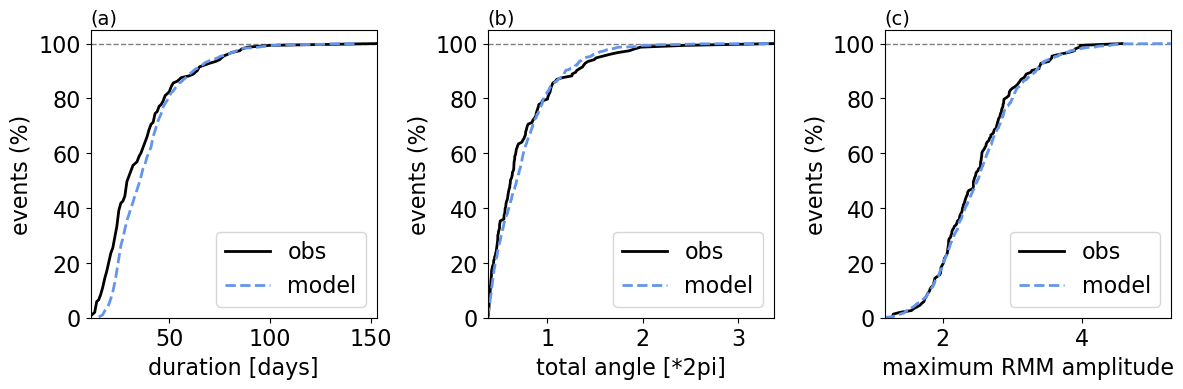

In [738]:
# plot statistics
fig, axs = subplots(1,3, figsize = (12,4))

#######################################################################################################
axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


duration_sorted = sort(duration_ref);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_ref)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

duration_sorted = sort(durations);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations)[1])
end

axs[1].plot(duration_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2, label = "model")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations; duration_ref])
max_d = maximum([durations; duration_ref])

axs[1].set_xlim([min_d,max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


total_angle_sorted = sort(angle_ref./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angle_ref)[1])
end

axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

total_angle_sorted = sort(angles./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles)[1])
end

axs[2].plot(total_angle_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2, label = "model")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles; angle_ref])
max_a = maximum([angles; angle_ref])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMM_ref);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMM_ref)[1])
end
#data = [data]

axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

RMM_sim_sorted = sort(maxRMMs);
data = [];
for m in RMM_sim_sorted
    cdf = sum(RMM_sim_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs)[1])
end

axs[3].plot(RMM_sim_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2, label = "model")


axs[3].set_xlabel("maximum RMM amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs; maxRMM_ref])
max_r = maximum([maxRMMs; maxRMM_ref])

axs[3].set_xlim([min_r,max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=14)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=14)
axs[3].text(min_r, 107, "(c)", fontsize=14)


########################################################################################################
tight_layout()
savefig("figures/comparison_obs_sim.png", dpi = 600, bbox_inches="tight", transparent = true)

In [764]:
for df in duration_ref
    println(df)
end


43.0
51.0
35.0
38.0
48.0
20.0
18.0
34.0
19.0
18.0
21.0
42.0
65.0
70.0
18.0
20.0
18.0
39.0
36.0
43.0
36.0
26.0
39.0
22.0
31.0
14.0
37.0
45.0
29.0
21.0
76.0
16.0
48.0
52.0
153.0
24.0
14.0
54.0
40.0
21.0
21.0
29.0
18.0
30.0
23.0
45.0
41.0
24.0
32.0
23.0
43.0
35.0
23.0
16.0
51.0
41.0
43.0
47.0
24.0
44.0
64.0
17.0
43.0
17.0
25.0
75.0
25.0
27.0
35.0
39.0
81.0
60.0
31.0
32.0
24.0
40.0
14.0
25.0
85.0
29.0
46.0
20.0
15.0
14.0
65.0
22.0
77.0
30.0
25.0
31.0
20.0
24.0
70.0
23.0
14.0
51.0
26.0
50.0
30.0
24.0
37.0
19.0
100.0
25.0
41.0
48.0
29.0
52.0
29.0
40.0
21.0
29.0
29.0
17.0
17.0
12.0
19.0
23.0
32.0
28.0
86.0
25.0
81.0
13.0
29.0
28.0
28.0
16.0
25.0
38.0
38.0
62.0
45.0
40.0
26.0
25.0
19.0
55.0
25.0
14.0
89.0
26.0
33.0
23.0
73.0
56.0
49.0
22.0
47.0
20.0
64.0
11.0
37.0


In [769]:
for df in angle_ref
    println(df)
end

8.231361433980151
6.521913674678556
4.937017439860323
2.618226747303696
5.706097255485039
3.730330878309978
2.633462368347161
5.408194160006371
2.956117791002831
3.5618588414097965
2.8872830332496444
3.7839027323578986
5.553338762188588
6.841554694360584
3.6057756256524347
3.4274333776136667
2.6141842718143913
6.552369697082918
3.9269210269915673
5.2888599039434085
4.617199937606468
3.746135696437136
5.637561733489105
2.3960088468369354
4.090287590407964
2.43081649403295
4.853887796727675
3.0620697825564944
3.168755379906231
2.4718202325857392
9.37262907567839
3.872392809929147
4.971801147025561
6.608608184067237
21.209269111460685
4.868761227527477
2.5165781009680463
7.923671223634278
2.59677984127235
2.81386676945623
3.14234826245822
2.4218733054948225
2.45068034970608
4.749885857483365
2.5410377691324246
6.909045162995007
6.319761076064756
5.019348616137907
4.847470307310038
2.6663179626412434
4.076564382369301
4.1269530453301515
2.4564385001992144
2.5782776978893773
8.1571511907666

In [768]:
for df in maxRMM_ref
    println(df)
end

2.8529141945094234
3.18326593020001
2.5730672159972334
2.560453311046767
2.2804545157560936
1.971703503311463
2.0038653150692847
2.0916943290493095
1.7941247655599992
1.9217307832035093
1.6750912831782776
1.9899673658656858
2.82319261847022
3.9708496986795225
1.8870949066161524
1.2847433960800845
2.140783336210209
2.8297045709235054
3.5423592911068806
2.956217317054722
2.5047275274371223
2.3331720338364117
2.771639317287604
1.6990171781404992
2.0226191881560807
1.7402078855941228
2.7415565215308804
2.357066611810372
2.7724097222934936
2.195449017116233
3.896407356878224
2.0856834149757697
2.6891576957312022
2.3173939335646336
3.265115165621057
2.079595043964809
1.7486135756017074
2.795104689224681
2.5619356770708803
1.8721983601892955
2.2818496196300964
2.4753835615512276
1.9583233257580688
2.537549690595498
1.5508672553707283
3.166442387418856
2.0400039555746234
2.3576913349121105
2.874445852232285
2.541863116851165
2.949054834557202
2.0724380075341884
2.0703579699722017
2.62427442213

### Initial phase

In [739]:
# number of (primary) events starting in each phase
starting_phases_ref = [19.0, 28.0, 20.0, 14.0, 17.0, 21.0, 18.0, 16.0];
starting_phases = zeros(8)
for nr in 1:NUM_REPEAT
    sps = events.starting_phase(seqs[nr], phase[nr,:]);
    starting_phases = starting_phases .+ sps;
end

### Final phase

In [740]:
# number of events ending in each phase
ending_phases_ref = [23.0, 19.0, 12.0, 16.0, 16.0, 20.0, 18.0, 29.0];
ending_phases = zeros(8)
for nr in 1:NUM_REPEAT
    eps = events.ending_phase(seqs[nr], phase[nr,:]);
    ending_phases = ending_phases .+ eps;
end

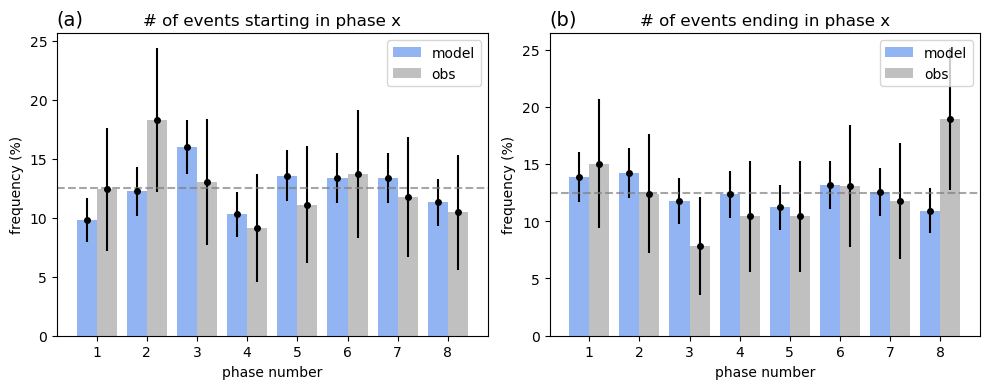

In [787]:
fig, axs = subplots(1,2, figsize = (10,4))


equal_likelyhood = 1/8*100;
width = 0.4


########################################################################################################
total = sum(starting_phases);
total_ref = sum(starting_phases_ref);

error_bars = zeros(8);
for i =1:8
    phat = starting_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = starting_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[1].bar(0.8:7.8, starting_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[1].errorbar(0.8:7.8, starting_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)

axs[1].bar(1.2:8.2, starting_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[1].errorbar(1.2:8.2, starting_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)


axs[1].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[1].set_ylabel("frequency (%)")
axs[1].set_xlabel("phase number")
axs[1].set_title("# of events starting in phase x")
axs[1].legend()

########################################################################################################

# number of events ending in each phase
total = sum(ending_phases)
total_ref = sum(ending_phases_ref);


error_bars = zeros(8);
for i =1:8
    phat = ending_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = ending_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[2].bar(0.8:7.8, ending_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[2].errorbar(0.8:7.8, ending_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)
axs[2].bar(1.2:8.2, ending_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[2].errorbar(1.2:8.2, ending_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)

axs[2].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[2].set_ylabel("frequency (%)")
axs[2].set_xlabel("phase number")
axs[2].set_title("# of events ending in phase x")

axs[2].legend()
########################################################################################################
max_s = axs[1].get_ylim()[2]
max_e = axs[2].get_ylim()[2]

axs[1].text(width/2, max_s + 3/100*max_s, "(a)", fontsize=14)
axs[2].text(width/2, max_e + 3/100*max_e, "(b)", fontsize=14)

########################################################################################################
tight_layout()
savefig("figures/starting_ending_phases.png", dpi = 600, bbox_inches="tight", transparent = true)


### Speed

In [706]:
speeds = [];

mean_speeds = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    speeds_nr, sub_seqs, main_seq = events.speed(seqs[nr], -ha_daily_filtered[:,nr,:], 2, phase[nr,:], Nx);
    append!(speeds, speeds_nr);
    mean_speeds[nr] = mean(speeds_nr);
end

mean_speed = mean(mean_speeds);
std_speed = std(mean_speeds);

println("Mean speed :", mean_speed, " +/- ", std_speed)


Mean speed :6.497194193931231 +/- 0.27094880353710177


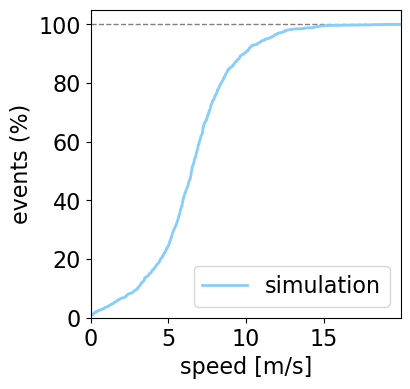

PyObject <matplotlib.legend.Legend object at 0x7fd8ea2f9690>

In [707]:
# speed distribution
# plot statistics

fig, ax = subplots(1,1, figsize = (4,4))

ax.axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


speeds_sorted = sort(speeds);
data = [];
for m in speeds_sorted
    cdf = sum(speeds_sorted .<= m)
    data = vcat(data, cdf/size(speeds)[1])
end

ax.plot(speeds_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2, label = "simulation")


ax.set_xlabel("speed [m/s]", fontsize = 16)
ax.set_ylabel("events (%)", fontsize = 16)
ax.tick_params(axis="both", labelsize=16)

ax.set_xlim([speeds_sorted[1], speeds_sorted[end]])
ax.set_ylim([0,105])
ax.legend(fontsize=16, loc = "lower right")



### ENSO comparison

In [742]:
seqN = [];
seqEN = [];
seqLN = [];
frac = [];
for nr in 1:NUM_REPEAT
    seqN_, seqEN_, seqLN_, frac_ = events.div_seq_ENSO_phases(seqs[nr], years_tracked, months_tracked, ENSO_ym, ENSO_phases);
    push!(seqN, seqN_);
    push!(seqEN, seqEN_);
    push!(seqLN, seqLN_);
    push!(frac, frac_);
end

#### Duration 

In [709]:
# Neutral
durations_N = [];
mean_durations_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqN[nr]);
    append!(durations_N, durations_nr);
    mean_durations_N[nr] = mean(durations_nr);
end

mean_duration_N = mean(mean_durations_N);
std_duration_N = std(mean_durations_N);

println("Mean duration for Neutral events :", mean_duration_N, " +/- ", std_duration_N)

# El Niño
durations_EN = [];
mean_durations_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqEN[nr]);
    append!(durations_EN, durations_nr);
    mean_durations_EN[nr] = mean(durations_nr);
end

mean_duration_EN = mean(mean_durations_EN);
std_duration_EN = std(mean_durations_EN);

println("Mean duration for El Niño events :", mean_duration_EN, " +/- ", std_duration_EN)


# La Niña
durations_LN = [];
mean_durations_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqLN[nr]);
    append!(durations_LN, durations_nr);
    mean_durations_LN[nr] = mean(durations_nr);
end

mean_duration_LN = mean(mean_durations_LN);
std_duration_LN = std(mean_durations_LN);

println("Mean duration for La Niña events :", mean_duration_LN, " +/- ", std_duration_LN)

Mean duration for Neutral events :39.59816823851911 +/- 2.272553674325432
Mean duration for El Niño events :38.32813500769383 +/- 4.937385931586896
Mean duration for La Niña events :40.66134474257539 +/- 6.805490151962368


In [710]:
# Neutral
max_durations_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqN[nr]);
    max_durations_N[nr] = maximum(durations_nr);
end

max_duration_N = mean(max_durations_N);
std_duration_N = std(max_durations_N);

println("Maximum duration for Neutral events :", max_duration_N, " +/- ", std_duration_N)

# El Niño
max_durations_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqEN[nr]);
    max_durations_EN[nr] = maximum(durations_nr);
end

max_duration_EN = mean(max_durations_EN);
std_duration_EN = std(max_durations_EN);

println("Maximum duration for El Niño events :", max_duration_EN, " +/- ", std_duration_EN)


# La Niña
max_durations_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqLN[nr]);
    max_durations_LN[nr] = maximum(durations_nr);
end

max_duration_LN = mean(max_durations_LN);
std_duration_LN = std(max_durations_LN);

println("Maximum duration for La Niña events :", max_duration_LN, " +/- ", std_duration_LN)

Maximum duration for Neutral events :90.66666666666667 +/- 21.53955387078342
Maximum duration for El Niño events :73.4 +/- 17.095529908638188
Maximum duration for La Niña events :80.93333333333334 +/- 23.93582690286278


In [743]:
println("Number of MJO events during Neutral ENSO: ", length(durations_N))
println("Number of MJO events during El Niño: ", length(durations_EN))
println("Number of MJO events during La Niña: ", length(durations_LN))

Number of MJO events during Neutral ENSO: 547
Number of MJO events during El Niño: 205
Number of MJO events during La Niña: 228


In [713]:
# Neutral

angles_N = [];

mean_angles_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqN[nr], phase[nr,:]);
    append!(angles_N, angles_nr);
    mean_angles_N[nr] = mean(angles_nr);
end

mean_angle_N = mean(mean_angles_N);
std_angle_N = std(mean_angles_N ./2 ./pi);

println("Mean angle for Neutral events:", mean_angle_N/2/pi, " +/- ", std_angle_N, " * 2pi.")


# El Niño
angles_EN = [];

mean_angles_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqEN[nr], phase[nr,:]);
    append!(angles_EN, angles_nr);
    mean_angles_EN[nr] = mean(angles_nr);
end

mean_angle_EN = mean(mean_angles_EN);
std_angle_EN = std(mean_angles_EN ./2 ./pi);

println("Mean angle for El Niño events:", mean_angle_EN/2/pi, " +/- ", std_angle_EN, " * 2pi.")


# La Niña
angles_LN = [];

mean_angles_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqLN[nr], phase[nr,:]);
    append!(angles_LN, angles_nr);
    mean_angles_LN[nr] = mean(angles_nr);
end

mean_angle_LN = mean(mean_angles_LN);
std_angle_LN = std(mean_angles_LN ./2 ./pi);

println("Mean angle for La Niña:", mean_angle_LN/2/pi, " +/- ", std_angle_LN, " * 2pi.")


Mean angle for Neutral events:0.7488527589805106 +/- 0.045165066238773845 * 2pi.
Mean angle for El Niño events:0.7307390232306089 +/- 0.09260541696445039 * 2pi.
Mean angle for La Niña:0.7921594494159343 +/- 0.14025139093970182 * 2pi.


In [714]:
# Neutral


max_angles_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqN[nr], phase[nr,:]);
    max_angles_N[nr] = maximum(angles_nr);
end

max_angle_N = mean(max_angles_N);
std_angle_N = std(max_angles_N ./2 ./pi);

println("Maximum angle for Neutral events:", max_angle_N/2/pi, " +/- ", std_angle_N, " * 2pi.")


# El Niño

max_angles_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqEN[nr], phase[nr,:]);
    max_angles_EN[nr] = maximum(angles_nr);
end

max_angle_EN = mean(max_angles_EN);
std_angle_EN = std(max_angles_EN ./2 ./pi);

println("Maximum angle for El Niño events:", max_angle_EN/2/pi, " +/- ", std_angle_EN, " * 2pi.")


# La Niña

max_angles_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqLN[nr], phase[nr,:]);
    max_angles_LN[nr] = maximum(angles_nr);
end

max_angle_LN = mean(max_angles_LN);
std_angle_LN = std(max_angles_LN ./2 ./pi);

println("Maximum angle for La Niña:", max_angle_LN/2/pi, " +/- ", std_angle_LN, " * 2pi.")


Maximum angle for Neutral events:1.7492267502191685 +/- 0.5767018747752706 * 2pi.
Maximum angle for El Niño events:1.4439250471262912 +/- 0.3837806423477584 * 2pi.
Maximum angle for La Niña:1.5535254411937107 +/- 0.5070351036997254 * 2pi.


In [717]:
# Neutral
maxRMMs_N = [];
mean_maxRMMs_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_N, maxRMMs_nr);
    mean_maxRMMs_N[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_N = mean(mean_maxRMMs_N);
std_maxRMM_N = std(mean_maxRMMs_N);

println("Mean of the maximum values of RMM for Neutral events:", mean_maxRMM_N, " +/- ", std_maxRMM_N)

# El Niño
maxRMMs_EN = [];
mean_maxRMMs_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqEN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_EN, maxRMMs_nr);
    mean_maxRMMs_EN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_EN = mean(mean_maxRMMs_EN);
std_maxRMM_EN = std(mean_maxRMMs_EN);

println("Mean of the maximum values of RMM for El Niño events:", mean_maxRMM_EN, " +/- ", std_maxRMM_EN)

# La Niña
maxRMMs_LN = [];
mean_maxRMMs_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqLN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_LN, maxRMMs_nr);
    mean_maxRMMs_LN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_LN = mean(mean_maxRMMs_LN);
std_maxRMM_LN = std(mean_maxRMMs_LN);

println("Mean of the maximum values of RMM for La Niña events:", mean_maxRMM_LN, " +/- ", std_maxRMM_LN)

Mean of the maximum values of RMM for Neutral events:2.534881951262608 +/- 0.0955263346929273
Mean of the maximum values of RMM for El Niño events:2.5718021507103006 +/- 0.13876883084099753
Mean of the maximum values of RMM for La Niña events:2.505402735170465 +/- 0.1776829346423961


In [718]:
# Neutral
max_maxRMMs_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_N[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_N = mean(max_maxRMMs_N);
std_maxRMM_N = std(max_maxRMMs_N);

println("Maximum of the maximum values of RMM for Neutral events:", max_maxRMM_N, " +/- ", std_maxRMM_N)

# El Niño
max_maxRMMs_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqEN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_EN[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_EN = mean(max_maxRMMs_EN);
std_maxRMM_EN = std(max_maxRMMs_EN);

println("Maximum of the maximum values of RMM for El Niño events:", max_maxRMM_EN, " +/- ", std_maxRMM_EN)

# La Niña
max_maxRMMs_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqLN[nr], amplitude[nr,:], phase[nr,:]);
    max_maxRMMs_LN[nr] = maximum(maxRMMs_nr);
end

max_maxRMM_LN = mean(max_maxRMMs_LN);
std_maxRMM_LN = std(max_maxRMMs_LN);

println("Maximum of the maximum values of RMM for La Niña events:", max_maxRMM_LN, " +/- ", std_maxRMM_LN)

Maximum of the maximum values of RMM for Neutral events:3.9631446389401694 +/- 0.3293045190134867
Maximum of the maximum values of RMM for El Niño events:3.7146243795977987 +/- 0.4328804913853791
Maximum of the maximum values of RMM for La Niña events:3.818973502681025 +/- 0.5313318509550359


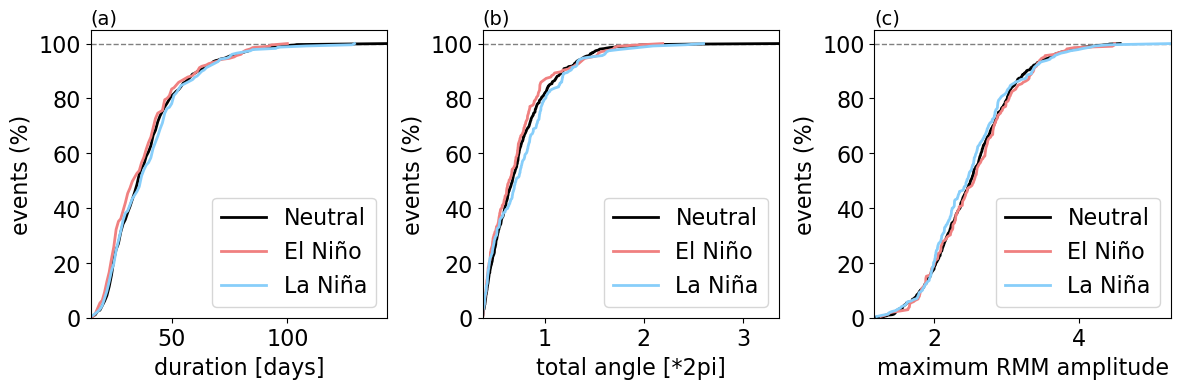

In [745]:
fig, axs = subplots(1,3, figsize = (12,4))

axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

duration_sorted = sort(durations_N);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_N)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2, label = "Neutral")

duration_sorted = sort(durations_EN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_EN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightcoral", alpha=1, linewidth=2, label = "El Niño")

duration_sorted = sort(durations_LN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_LN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2, label = "La Niña")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations_LN; durations_EN; durations_N])
max_d = maximum([durations_LN; durations_EN; durations_N])

axs[1].set_xlim([min_d, max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

total_angle_sorted = sort(angles_N./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_N)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2, label = "Neutral")

total_angle_sorted = sort(angles_EN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_EN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightcoral", alpha=1, linewidth=2, label = "El Niño")

total_angle_sorted = sort(angles_LN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_LN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2, label = "La Niña")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles_LN; angles_EN; angles_N])
max_a = maximum([angles_LN; angles_EN; angles_N])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")
########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMMs_N);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_N)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2, label = "Neutral")

max_amplitude_sorted = sort(maxRMMs_EN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_EN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightcoral", alpha=1, linewidth=2, label = "El Niño")

max_amplitude_sorted = sort(maxRMMs_LN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_LN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2, label = "La Niña")


axs[3].set_xlabel("maximum RMM amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])
max_r = maximum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])


axs[3].set_xlim([min_r, max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")



########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=14)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=14)
axs[3].text(min_r, 107, "(c)", fontsize=14)


########################################################################################################
tight_layout()
savefig("figures/ENSO_sim.png", dpi = 300, bbox_inches="tight", transparent = true)

-0.5083146813321012

In [762]:
for d in angles_LN
    println(d)
end

6.124762646217743
2.521111082639448
3.280066472719747
5.571033813532357
2.846724224237608
4.802362882692644
5.229824796905658
2.5951611237206875
2.8234773404918503
2.3910123673460713
6.474243412033852
4.989434948663252
4.751530029061119
5.354487011296621
2.497471040665981
3.156810863618189
2.988465446939518
4.2342041890347755
2.431292051834275
4.367110349410946
3.6191474977610683
7.176499561276373
5.256378430298537
4.807281924321507
2.7636106894770553
5.013574271888873
5.961290581613585
2.6837352123640303
5.034392478175064
4.416342095522697
8.431388300587658
5.840513137999743
7.7258908623000675
6.401029994836687
2.373043555449156
2.4529132891191834
7.255092967572561
2.4937842446393494
7.3717937129818525
6.229343925054645
4.459001254453739
5.400669806835947
2.479769847385551
3.257107160526796
7.4320949915896435
6.755780663534248
5.408725196273364
5.1921497352207755
2.8225749248778005
3.43945057417715
4.307711195478115
2.3747985660045217
8.348961885436754
5.963111806894156
5.739815479088

#### Speed

In [720]:
speeds_N = [];

mean_speeds_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    speeds_nr, sub_seqs, main_seq = events.speed(seqN[nr], -ha_daily_filtered[:,nr,:], 2, phase[nr,:], Nx);
    append!(speeds_N, speeds_nr);
    mean_speeds_N[nr] = mean(speeds_nr);
end

mean_speed_N = mean(mean_speeds_N);
std_speed_N = std(mean_speeds_N);

println("Mean speed during Neutral events :", mean_speed_N, " +/- ", std_speed_N)

# El Niño
speeds_EN = [];

mean_speeds_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    speeds_nr, sub_seqs, main_seq = events.speed(seqEN[nr], -ha_daily_filtered[:,nr,:], 2, phase[nr,:], Nx);
    append!(speeds_EN, speeds_nr);
    mean_speeds_EN[nr] = mean(speeds_nr);
end

mean_speed_EN = mean(mean_speeds_EN);
std_speed_EN = std(mean_speeds_EN);

println("Mean speed during El Niño events :", mean_speed_EN, " +/- ", std_speed_EN)

# La Niña
speeds_LN = [];

mean_speeds_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    speeds_nr, sub_seqs, main_seq = events.speed(seqLN[nr], -ha_daily_filtered[:,nr,:], 2, phase[nr,:], Nx);
    append!(speeds_LN, speeds_nr);
    mean_speeds_LN[nr] = mean(speeds_nr);
end

mean_speed_LN = mean(mean_speeds_LN);
std_speed_LN = std(mean_speeds_LN);

println("Mean speed during La Niña events :", mean_speed_LN, " +/- ", std_speed_LN)


Mean speed during Neutral events :6.549140739816532 +/- 0.3322367868673022
Mean speed during El Niño events :6.395127224880619 +/- 0.8566948020115098
Mean speed during La Niña events :6.561524544149787 +/- 0.6618124874114428


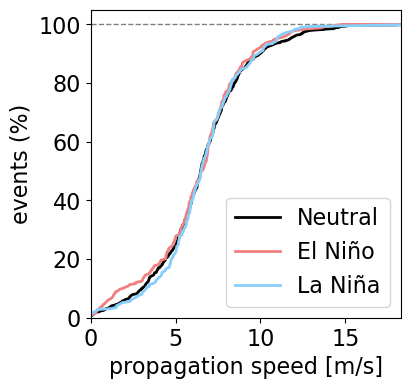

In [721]:
# plot statistics

# histogram of maximum amplitude
fig, ax = subplots(1,1, figsize = (4,4))
ax.axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

speed_sorted = sort(speeds_N);
data = [];
for m in speed_sorted
    cdf = sum(speed_sorted .<= m)
    data = vcat(data, cdf/size(speeds_N)[1])
end
ax.plot(speed_sorted, data*100, color="black", alpha=1, linewidth=2, label = "Neutral")
ax.set_xlim([speed_sorted[1], speed_sorted[end]])

speed_sorted = sort(speeds_EN);
data = [];
for m in speed_sorted
    cdf = sum(speed_sorted .<= m)
    data = vcat(data, cdf/size(speeds_EN)[1])
end
data = [data;1.0]
ax.plot([speed_sorted;maximum(speeds_EN)*2], data*100, color="lightcoral", alpha=1, linewidth=2, label = "El Niño")

speed_sorted = sort(speeds_LN);
data = [];
for m in speed_sorted
    cdf = sum(speed_sorted .<= m)
    data = vcat(data, cdf/size(speeds_LN)[1])
end
data = [data;1.0]
ax.plot([speed_sorted;maximum(speeds_LN)*2], data*100, color="lightskyblue", alpha=1, linewidth=2, label = "La Niña")


ax.set_xlabel("propagation speed [m/s]", fontsize = 16)
ax.set_ylabel("events (%)", fontsize = 16)
ax.tick_params(axis="both", labelsize=16)


ax.set_ylim([0,105])
ax.legend(fontsize=16, loc = "lower right")


savefig("figures/speed_ENSO_sim.png", dpi = 300, bbox_inches="tight", transparent = true)


In [722]:
compo1 = zeros(64);
compo2 = zeros(64);
compo3 = zeros(64);
compo4 = zeros(64);
compo5 = zeros(64);
compo6 = zeros(64);
compo7 = zeros(64);
compo8 = zeros(64);

for nr in 1:NUM_REPEAT
    compo1 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p1", true, 3);
    compo2 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p2", true, 3);
    compo3 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p3", true, 3);
    compo4 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p4", true, 3);
    compo5 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p5", true, 3);
    compo6 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p6", true, 3);
    compo7 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p7", true, 3);
    compo8 += events.composites(-ha_daily_filtered[:,nr,:], seqs[nr], phase[nr,:], "p8", true, 3);
end

337.0
335.0
339.0
347.0
388.0
331.0
322.0
393.0
335.0
334.0
343.0
316.0
336.0
307.0
366.0
363.0
364.0
306.0
359.0
317.0
328.0
378.0
351.0
359.0
229.0
314.0
395.0
278.0
312.0
335.0
293.0
323.0
344.0
324.0
322.0
361.0
267.0
381.0
311.0
273.0
266.0
258.0
291.0
280.0
300.0
340.0
347.0
314.0
341.0
329.0
315.0
313.0
342.0
376.0
342.0
360.0
330.0
331.0
377.0
338.0
363.0
384.0
309.0
403.0
274.0
261.0
325.0
270.0
292.0
274.0
285.0
301.0
276.0
256.0
273.0
240.0
251.0
286.0
259.0
223.0
378.0
283.0
346.0
329.0
313.0
344.0
340.0
299.0
266.0
313.0
334.0
304.0
296.0
334.0
228.0
316.0
420.0
315.0
376.0
357.0
374.0
394.0
352.0
386.0
340.0
268.0
335.0
329.0
286.0
351.0
262.0
287.0
330.0
336.0
299.0
320.0
274.0
352.0
341.0
352.0


In [723]:

compo1 = compo1 ./NUM_REPEAT;
compo2 = compo2 ./NUM_REPEAT;
compo3 = compo3 ./NUM_REPEAT;
compo4 = compo4 ./NUM_REPEAT;
compo5 = compo5 ./NUM_REPEAT;
compo6 = compo6 ./NUM_REPEAT;
compo7 = compo7 ./NUM_REPEAT;
compo8 = compo8 ./NUM_REPEAT; 


In [724]:
for e in compo1
    print(e)
    print(", ")
end

-0.09698751489244962, -0.06501527314642241, -0.046360255000979955, -0.04136753183289305, -0.04923584294938628, -0.06806434003172925, -0.09498771024571391, -0.12638986741671887, -0.15817985789096914, -0.18610840700677012, -0.20610007739315764, -0.21457461703578148, -0.20873186480246372, -0.18677749113788925, -0.14807163999049008, -0.09318880413700288, -0.023884484719331977, 0.05702824813730913, 0.14588189689969197, 0.23842059820434824, 0.33010736230017884, 0.41644762283980497, 0.4933031911365923, 0.5571718323931161, 0.60541085772999, 0.6363880725561426, 0.6495497073391209, 0.6454020379241565, 0.6254106711962568, 0.5918283075795822, 0.5474676148731864, 0.4954401688260374, 0.43888487728700554, 0.38070971161109585, 0.3233689045628045, 0.26869420069119854, 0.21779358995996295, 0.17102468075898442, 0.1280430317900739, 0.08791896756262202, 0.04931024699882953, 0.010672978422141837, -0.029510188495023647, -0.07250702051587904, -0.11913966282505245, -0.16963491237747796, -0.22353581537026096, -

In [725]:
for e in compo2
    print(e)
    print(", ")
end

-0.11854790603302413, -0.08635355630002751, -0.0639503745608879, -0.05474264088258845, -0.06118953518065871, -0.08452621814264066, -0.12457706749832893, -0.17968035466014048, -0.24673451665190704, -0.3213660307891559, -0.39820859544102866, -0.47127373958034635, -0.5343849508978901, -0.5816416242636853, -0.6078760993163362, -0.6090670564511202, -0.5826755967600384, -0.5278762068813311, -0.44566302796490126, -0.3388217330492148, -0.2117680503427498, -0.07026465900937975, 0.07896206099300684, 0.22867593512697598, 0.3716204708383242, 0.5010060984547012, 0.610957746474438, 0.6968887540090434, 0.7557733158655401, 0.7862980805535627, 0.7888834643937473, 0.765575866907993, 0.7198223814041123, 0.6561489203362083, 0.5797701443197446, 0.49616458523992013, 0.41065048971966384, 0.3279970277129188, 0.25210171878066967, 0.18575858017498403, 0.1305331669539987, 0.08675109193349069, 0.05359662130682898, 0.029308408425539903, 0.01145117589431545, -0.0027641095273378278, -0.016142775298484853, -0.0311838

In [726]:
for e in compo3
    print(e)
    print(", ")
end

-0.03891679891960003, -0.01679599736242651, 0.0031233572096676415, 0.016002264302179946, 0.0173017610538085, 0.0032396583408048, -0.02880267636510266, -0.07996105879459307, -0.14968733286717895, -0.23568716905784334, -0.3340060034031753, -0.43925970867139946, -0.5449941364605129, -0.6441464304259487, -0.7295719589423802, -0.7945946400699397, -0.8335358714445128, -0.8421784733082673, -0.8181269254521936, -0.7610333357940267, -0.672669346198871, -0.5568366624928769, -0.41912204508885603, -0.26651530993729233, -0.1069200973980688, 0.05140407397745712, 0.20042437739764418, 0.33289585807428806, 0.4428570987347044, 0.5260217801298068, 0.5800362549975087, 0.6045843966196607, 0.6013336153743194, 0.5737289905832896, 0.5266548401556894, 0.4659937081621631, 0.3981208015703785, 0.3293766883094424, 0.26556219734924413, 0.21149686847368426, 0.17067623381759126, 0.1450542195629705, 0.13496582686076847, 0.1391929574191733, 0.15516385744592437, 0.17926523262839636, 0.20723661606105193, 0.23460985637893

In [727]:
for e in compo4
    print(e)
    print(", ")
end

0.02847224273302213, 0.024151868532932504, 0.029737971159680514, 0.042073855338347406, 0.05716002812553436, 0.07051705774823695, 0.07759913511840276, 0.07422256350326098, 0.056971753188518326, 0.023546883573267594, -0.026977907884661968, -0.0940095337941808, -0.17541837689950057, -0.26765154483064435, -0.36596922905150725, -0.46478587878049915, -0.5580888434531273, -0.6399003621350362, -0.704744871915404, -0.7480829120311824, -0.7666754844893066, -0.7588483831583559, -0.72463424715357, -0.665780234277419, -0.5856203871982649, -0.4888230307570981, -0.3810339371150865, -0.2684446440584841, -0.15732147765346305, -0.05353399258868617, 0.037878562547745444, 0.11306750766077055, 0.16963279540929208, 0.20675869056759993, 0.22521728445673428, 0.22724124814892951, 0.2162782336870027, 0.1966492221818124, 0.17314105146778705, 0.15056866383304285, 0.133344852943502, 0.1250942797593621, 0.12834437071771684, 0.14431877865571785, 0.1728499865710047, 0.2124171599598337, 0.2603044149209313, 0.312864213

In [728]:
for e in compo5
    print(e)
    print(", ")
end

0.08532545792080103, 0.057951105021256645, 0.0443216191979792, 0.044811255775042115, 0.05858355199899477, 0.08362463305106083, 0.11687331377648555, 0.15443918075504928, 0.19189239734304095, 0.224602827963576, 0.24810175495388956, 0.2584373365608121, 0.2524952178165475, 0.2282583447943944, 0.18498483372135346, 0.12328931285842461, 0.04512094038637208, -0.04636034427747782, -0.14699955356491903, -0.25193717904489077, -0.3559513492259935, -0.45382441123068323, -0.5407049494103523, -0.6124368766497613, -0.6658301966454057, -0.6988530771203827, -0.7107315591124305, -0.7019509831464917, -0.6741613781818104, -0.6299969411876181, -0.5728266693483254, -0.5064586130527318, -0.4348236496524137, -0.36166586070498924, -0.29026544869734633, -0.22321677324851455, -0.1622788310602765, -0.10830881987805224, -0.061281906511719636, -0.020392623602933407, 0.015773878080001375, 0.049018569627231515, 0.08127555034467303, 0.11435399372056007, 0.1496998780894647, 0.18820028715495524, 0.23004896499896882, 0.27

In [729]:
for e in compo6
    print(e)
    print(", ")
end

0.12942370110662718, 0.09157577003314517, 0.06156716973150951, 0.04319521581907499, 0.03950608911677405, 0.05247368424747394, 0.08275493867508718, 0.12954568927622423, 0.19055302207698652, 0.26209048607376567, 0.3392922428030777, 0.41643209493555633, 0.4873242467989704, 0.5457753818156923, 0.586052830469123, 0.6033316764387238, 0.59408479407815, 0.5563839540341013, 0.4900869479160512, 0.3968946128451798, 0.28027194720248255, 0.14523834620180812, -0.0019575500397713873, -0.15425368262362443, -0.3042491501231057, -0.4447010079114416, -0.5690051469100842, -0.6716246054183103, -0.7484331447530598, -0.7969489921823381, -0.8164427221206281, -0.8079135423731494, -0.7739389099777388, -0.7184125283561886, -0.6461945312550323, -0.5627043177393279, -0.47349052682782045, -0.38381371802615294, -0.29827539567771394, -0.22052227804225064, -0.15304760215719104, -0.09710240855918204, -0.05271994582300981, -0.018846429988150417, 0.006437753143656301, 0.025629917532481828, 0.041478944241633856, 0.0566528

In [730]:
for e in compo7
    print(e)
    print(", ")
end

0.08252855498199341, 0.06118255641154367, 0.03876188436819885, 0.0199428976681308, 0.009398295219931308, 0.0113424624672532, 0.02910040838067542, 0.06473946619738816, 0.11879812165261469, 0.190138466769947, 0.2759385129283935, 0.3718288024669898, 0.4721654389021263, 0.5704198679333076, 0.6596555007035892, 0.733053465544167, 0.7844450885951652, 0.808807557484288, 0.8026817353669541, 0.7644770731607394, 0.6946375277818756, 0.5956535906038746, 0.4719180280472325, 0.3294356872860353, 0.17540965306382297, 0.017736152773351298, -0.13555195428520625, -0.27684912606088213, -0.39950404965342784, -0.49826822292727135, -0.5696315026804749, -0.6120193518757607, -0.6258379987793039, -0.6133662736336482, -0.5785054534613885, -0.5264099649947758, -0.46303130444361285, -0.3946142404747683, -0.32718772471542545, -0.266092681492862, -0.2155850337961321, -0.17854529803749883, -0.15631647132378435, -0.1486805849952116, -0.15397219544859808, -0.16931527543006206, -0.19095947272942004, -0.214683416637301, -

In [731]:
for e in compo8
    print(e)
    print(", ")
end

-0.009658103614493086, -0.0024123568171489367, -0.00449314037462534, -0.012921138204273864, -0.02399312936923265, -0.03361909526524277, -0.03769896669827396, -0.03250654815064087, -0.015047284909455167, 0.016641460547001625, 0.0632742458715608, 0.12420509845589352, 0.1974296339083959, 0.2797028855287831, 0.3667641302345678, 0.45365084162758607, 0.5350762335009122, 0.6058393363839689, 0.6612336521099865, 0.6974204093088328, 0.7117353028189309, 0.7029031023635807, 0.6711421944114692, 0.6181503236161405, 0.5469727438398303, 0.46176382735120314, 0.36746207727294933, 0.2694056864670379, 0.17292067505856595, 0.08291580579248771, 0.0035177415289400476, -0.062223659153973904, -0.11253610342161008, -0.1470159658438225, -0.1666034022079132, -0.17344503105662265, -0.17065727013686857, -0.1620117797304366, -0.15157094990814934, -0.14330542425132498, -0.14072693872132677, -0.1465681702878511, -0.1625369820670663, -0.18916580075743694, -0.2257684498931015, -0.2705073213271411, -0.32056411715810673, 

In [62]:
function taper(y, taper_percent)
    println(size(y))
    x = ones(size(y)).*y;
    
    if taper_percent < 0.0 || taper_percent > 0.5
        throw(ArgumentError("Taper percentage must be between 0.0 and 0.5"))
    end

    n = length(x)
    
    taper_length = Int(floor(n*taper_percent))

    for i in 1:taper_length
        x[i] = x[i] * i / taper_length
        x[n - i + 1] = x[n - i + 1] * i / taper_length
    end
    
    return x
end


taper (generic function with 1 method)

In [ ]:
############################# remove the first three harmonics from the signal
term_ = ha_daily[:,1,:];

freqs = fftshift(fftfreq(Nd, Nd))/Nd;
idx1 = findall(x-> abs(x) <= 3/365.0, freqs);

for pt in 1:64 # filter each spatial point separately
    tmp = fftshift(fft(term_[pt,:]));
    tmp[idx1].=0;
    term_[pt,:] = real(ifft(ifftshift(tmp)));
end

##############################
window_size = 120;
nd = window_size +1;

kg =-fftshift(fftfreq(Nx,Nx));
wg = fftshift(fftfreq(nd,nd))/nd;

PSD = zeros(length(kg), length(wg))

total = 0;

for jjj in 1:(floor(Int,Nd/window_size)-window_size)
    total +=1;
    
    x = term_[:,jjj*window_size:(jjj+1)*window_size-1];
    # tapering
    taper_percent = 0.15; # tapper 10 percent of the segment
    tapered_segment = taper(x, taper_percent);
    ####################################
    
    xcon=((1:Nx)*0);
    xcon=hcat(xcon,tapered_segment);  
    tapered_segment = xcon; xcon = 0;
    println(size(tapered_segment))
    
    term = spectrum(tapered_segment, Nx, nd) # 
    #############################
    
    PSD = PSD .+ term;
end

PSD = real.(PSD) ./total;
#############################OK
nxsmoo=     1; # x size of smooth (odd) (ref=1)
ntsmoo=     25; # t size of smooth (odd) (ref=25)
# smooth data
sz = [nxsmoo,ntsmoo]'; # x size of smooth, t size of smooth
padSize = Int.((sz .-1) ./2);
smooth_ = ones((sz[1],sz[2])) ./ (sz[1]*sz[2]); 

# pad data
X = padreplicate(PSD,padSize);
# perform the convolution
Y = conv(X, smooth_)  # Convolution (1 dimensional convolution, I think)

# Extract the 'valid' part of the result
Y_valid = Y[:,1:size(X)[2]];
Y_valid = Y_valid[:,padSize[2]+1:end-padSize[2]];

PSD = Y_valid;
###############################
## subsampling
#nku=1; # k-space between samples 
#nwu=2; # w-space between samples 
#
## undersample for figure
#PSD=Y_valid[1:nku:end,1:nwu:end];
#kg=kg[1:nku:end];
#wg=wg[1:nwu:end]; 